### Detect difficulty of English text and visualize it

In [1]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt
import math

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, Subset
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel

from models.attention import SimpleAttention
from models.attention2 import SimpleAttention2
from models.bert import BERTClassification
from models.simple import SimpleClassification
from dataset.cefr_leveled_texts import CEFRLeveledTexts
from dataset.cefr_sp import CEFR_SP
from util.metrics import ClassificationMetrics

LEARNING_RATE = 3e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
NUM_EPOCHS = 10
LOAD_FROM = None
DATA_ROOT = Path("training_data")
NUM_CLASS = 6
EXP_FOLDER = Path("exp1")

/home/cyrus/virtualenv/text/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Dataset and Model

In [2]:
# dataset = CEFRLeveledTexts(DATA_ROOT / "cefr_leveled_texts.csv")
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.7, 0.1, 0.2])

train_dataset = CEFR_SP("training_data/CEFR-SP", split="train")
val_dataset = CEFR_SP("training_data/CEFR-SP", split="dev")
test_dataset = CEFR_SP("training_data/CEFR-SP", split="test")

In [3]:
# train_dataset = Subset(train_dataset, np.arange(300))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataset = Subset(val_dataset, np.arange(20))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
# model = SimpleAttention(NUM_CLASS, vocab_size=len(tokenizer)).to(DEVICE)
model = SimpleClassification(NUM_CLASS, vocab_size=len(tokenizer)).to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")  # to get average easily
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### Training

In [4]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch [{epoch}/{NUM_EPOCHS}]")

    model.train()
    train_loss = 0
    for batch_idx, (sentences, labels) in enumerate(train_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 500 == 0:
            print(f"[Batch {batch_idx:4d}/{len(train_loader)}] Loss: {loss.item()/BATCH_SIZE:.4f}")

    print(f"Total train loss: {train_loss/len(train_dataset):.4f}")

    model.eval()
    val_truths = []
    val_outputs = []
    for batch_idx, (sentences, labels) in enumerate(val_loader):
        inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
        labels = torch.LongTensor(labels).to(DEVICE)

        outputs = model(**inputs)
        loss = criterion(outputs, labels)

        val_truths += labels.detach().cpu().tolist()
        val_outputs.append(outputs.detach().cpu())

    val_outputs = torch.cat(val_outputs)  # from list of tensor to numpy array
    metrics = ClassificationMetrics(val_truths, val_outputs)
    metrics.print_report()

    print()

Epoch [0/10]
[Batch    0/1795] Loss: 1.4978
[Batch  500/1795] Loss: 1.4539
[Batch 1000/1795] Loss: 1.3802
[Batch 1500/1795] Loss: 1.6916
Total train loss: 1.2668
Accuracy: 45.31% | Precision: 0.2444
Recall:   0.2503 | F1 score:  0.2257

Epoch [1/10]
[Batch    0/1795] Loss: 1.1711


### Visualize weights

In [ ]:
batch_idx, (sentences, labels) = next(enumerate(val_loader))
inputs = tokenizer(sentences, return_tensors="pt", padding=True).to(DEVICE)
tokens_list = [tokenizer.convert_ids_to_tokens(ids) for ids in inputs["input_ids"]]

model.eval()
_, attention = model.get_attention_output(**inputs)
outputs = model(**inputs)
predictions = torch.argmax(outputs, axis=1)

cls_attn = attention[:, 0, :]
print(attention.shape)
print(cls_attn.sum())
print(predictions)

for tokens, attn in zip(tokens_list, cls_attn):
    for t in tokens:
        print(f"{t:>15}", end="")
    print()
    for a in attn.tolist():
        print(f"{a:15.4f}", end="")
    print()

torch.Size([4, 14, 14])
tensor(4., device='cuda:0', grad_fn=<SumBackward0>)
tensor([1, 1, 1, 1], device='cuda:0')
          [CLS]             It              '              s             10              p              .              m              .          [SEP]          [PAD]          [PAD]          [PAD]          [PAD]
         0.1175         0.1386         0.1401         0.0960         0.0978         0.1073         0.0714         0.1038         0.0711         0.0564         0.0000         0.0000         0.0000         0.0000
          [CLS]            Roy            did              n              '              t           like            his     girlfriend              '              s          meals              .          [SEP]
         0.0928         0.0859         0.0916         0.0720         0.0682         0.0644         0.0827         0.0627         0.0676         0.0758         0.0525         0.0708         0.0602         0.0528
          [CLS]              I           s

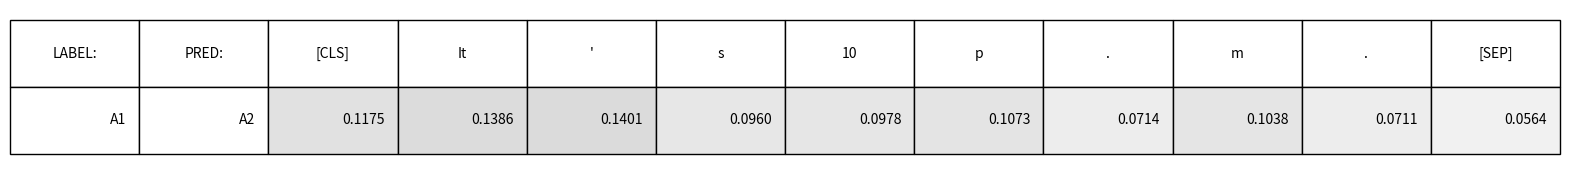

In [ ]:
import matplotlib.font_manager as fm

fprop = fm.FontProperties(fname="resource/NotoSansJP-Regular.ttf")

i = 0
max_length = 12

tokens: list[str] = tokens_list[i]
attn = cls_attn[i].tolist()
label = CEFRLeveledTexts.target2label(labels[i].item())
prediction = CEFRLeveledTexts.target2label(predictions[i].item())

words = []
values = []
for t, a in zip(tokens, attn):
    if t == "[PAD]":
        break
    if t.startswith("##"):
        # combine subwords
        words[-1] = words[-1] + t[2:]
        values[-1] += a
    else:
        words.append(t)
        values.append(a)

words = ["LABEL:", "PRED:"] + words
attn_strs = [label, prediction] + [f"{a:.4f}" for a in values]
colors = ["w", "w"] + [str(1 - a) for a in values]


def plot_pairs(plt, words, values, colors, max_length=max_length):
    seq_length = len(words)
    if seq_length < max_length:
        words += [""] * (max_length - seq_length)
        values += [""] * (max_length - seq_length)
        colors += ["w"] * (max_length - seq_length)
    plt.axis("off")
    table = plt.table(cellText=[values], cellColours=[colors], colLabels=words, loc="center")
    for cell in table._cells:
        table._cells[cell].set_text_props(fontproperties=fprop)
    table.scale(1, 4)


num_lines = math.ceil(len(words) / max_length)
fig, ax = plt.subplots(num_lines, 1, figsize=(20, 2 * num_lines))
if num_lines == 1:
    plot_pairs(ax, words, attn_strs, colors)
else:
    for i in range(num_lines):
        s, e = i * max_length, (i + 1) * max_length
        plot_pairs(ax[i], words[s:e], attn_strs[s:e], colors[s:e])

plt.show()

In [ ]:
line = "Replace me by any text you'd like."
line2 = "Some weights of the model checkpoint at bert-base-cased were not used"
inputs = tokenizer([line, line2], return_tensors="pt", padding="max_length").to(DEVICE)
print(inputs.keys())
print(inputs["attention_mask"] == 0)
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]))
print(tokenizer.convert_ids_to_tokens(inputs["input_ids"][1]))

out = model(**inputs)
print(out.shape)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]], device='cuda:0')
['[CLS]', 'Rep', '##lace', 'me', 'by', 'any', 'text', 'you', "'", 'd', 'like', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '